## Example for a CNN-LSTM model to predict BTC close price over next 15 min

In [150]:
import os
from google.colab import drive
drive.mount('/content/drive')
os.chdir('/content/drive/MyDrive/Colab Notebooks/sats4u/')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [151]:
!cat requirements.txt

python-binance==1.0.16
mplfinance==0.12.9b0
tensorflow==2.8.2
pydot==1.3.0
graphviz==0.10.1
scikit-learn==1.0.2
backtrader==1.9.76.123
pyfolio-reloaded==0.9.3

In [152]:
! pip install -r requirements.txt

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [153]:
import backtrader as bt
from backtrader.feeds import PandasData
import pyfolio as pf
from pathlib import Path
import csv

In [154]:
import json
import sys
import pandas as pd
import numpy as np
import math
from datetime import datetime
import time
import matplotlib.pyplot as plt
import seaborn as sns
import mplfinance as mpf
from sklearn.preprocessing import MinMaxScaler
from tensorflow import keras
import tensorflow as tf
import src.loadcrypto as lc
import src.featbuild as fb
import src.candles2timeseries as c2t
import src.sats2model as s2m
import src.timeutils as tu
import src.sats2backtest as s2b


# settings for reproducible results
#os.environ['CUDA_VISIBLE_DEVICES'] = ''
np.random.seed(420)
os.environ['PYTHONHASHSEED'] = '0'
tf.random.set_seed(420)

## Load Asset Details, Binance client data and Download 15m candles from Binance

In [155]:
data_folder = "data/"
asset_details = pd.read_csv(data_folder + 'asset_details.csv')

In [156]:
secret_data_folder = '/content/drive/MyDrive/Colab Notebooks/crypto_project/crypto_data/'
secrets_filename = secret_data_folder+'data.json'

In [157]:
crypto = lc.CryptoData(asset_details,data_folder)
crypto.load_binance_client(secrets_filename,data1_str = 'DATA1',data2_str = 'DATA2i')
crypto.trade_time_units(dt=60,kline_size="15m",starting_date = '1 Mar 2017')

In [158]:
tickers=crypto.asset_details["Ticker"]
tickers = list(tickers[tickers=='BTCUSDT'].values)

In [159]:
ldata_df = crypto.load_cryptos(tickers,save = False)                             

All caught up..!
size of dataset: (177466, 8)


In [160]:
ldata_df

,timestamp,OpenBitcoin,HighBitcoin,LowBitcoin,CloseBitcoin,VolumeBitcoin,CountBitcoin,Date,Future Date
timestamp,,,,,,,,,
1502942400,1502942400,4261.48,4280.56,4261.48,4261.48,2.189061,9.0,2017-08-17 04:00:00,2017-08-17 04:15:00
1502943300,1502943300,4261.48,4270.41,4261.32,4261.45,9.119865,40.0,2017-08-17 04:15:00,2017-08-17 04:30:00
1502944200,1502944200,4280.00,4310.07,4267.99,4310.07,21.923552,58.0,2017-08-17 04:30:00,2017-08-17 04:45:00
1502945100,1502945100,4310.07,4313.62,4291.37,4308.83,13.948531,64.0,2017-08-17 04:45:00,2017-08-17 05:00:00
1502946000,1502946000,4308.83,4328.69,4304.31,4304.31,5.101153,44.0,2017-08-17 05:00:00,2017-08-17 05:15:00
...,...,...,...,...,...,...,...,...,...
1663158600,1663158600,20213.81,20347.91,20126.01,20313.94,6288.667940,148727.0,2022-09-14 12:30:00,2022-09-14 12:45:00
1663159500,1663159500,20313.95,20334.45,20240.44,20309.11,5198.616640,86682.0,2022-09-14 12:45:00,2022-09-14 13:00:00
1663160400,1663160400,20309.08,20389.99,20271.64,20378.92,5391.864140,83950.0,2022-09-14 13:00:00,2022-09-14 13:15:00


### Plot wick Candles and build features from technical analysis

In [161]:
can_btc = fb.Candles(ldata_df,"Bitcoin")
can_btc.candles

,Low,High,Open,Close,Volume
Date,,,,,
2017-08-17 04:00:00,4261.48,4280.56,4261.48,4261.48,2.189061
2017-08-17 04:15:00,4261.32,4270.41,4261.48,4261.45,9.119865
2017-08-17 04:30:00,4267.99,4310.07,4280.00,4310.07,21.923552
2017-08-17 04:45:00,4291.37,4313.62,4310.07,4308.83,13.948531
2017-08-17 05:00:00,4304.31,4328.69,4308.83,4304.31,5.101153
...,...,...,...,...,...
2022-09-14 12:30:00,20126.01,20347.91,20213.81,20313.94,6288.667940
2022-09-14 12:45:00,20240.44,20334.45,20313.95,20309.11,5198.616640
2022-09-14 13:00:00,20271.64,20389.99,20309.08,20378.92,5391.864140


/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:5182: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  downcast=downcast,
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1951: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[selected_item_labels] = value
/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:5047: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-v

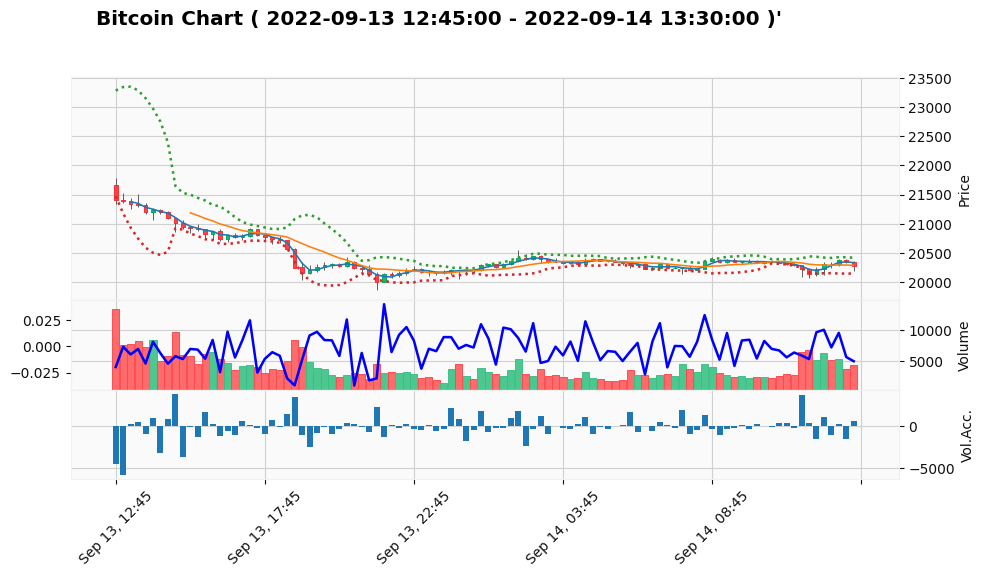

In [162]:
can_btc.buildfeatures()
can_btc.ta_fullplot()

# Generate normalized timeseries

In [163]:
ts_btc = c2t.Candle2TimeSeries(can_btc.candles, laststeps = 50000, step_back = 48, candle_step_str = "15m",
                lownorm = 0.2, upnorm= 0.8)

ts_btc.candles2ts()

Candles Normalized
Extracted last 50000 steps
Generated time-series
Normalized 'candles_norm' with shape : (50000, 9)
Feature data 'x_candles' with size : 49952
Feature data with time intervals 'x_time' with size : 49952


In [164]:
ts_btc.x_candles
ts_btc.x_time
ts_btc.scaler
ts_btc.y[-10:]

[0.35913786117825947,
 0.3589901804127232,
 0.3584732066847854,
 0.35771750363056143,
 0.35836813664568,
 0.3592798058844685,
 0.35923582942962634,
 0.3598714394322212,
 0.3595069720435395,
 0.35892599117739454]

## Train a CNN-LSTM model 

In [165]:
btc_model =  s2m.TimeSeries2Model(ts_btc.x_candles, ts_btc.x_time, ts_btc.y, ts_btc.scaler, split_fraction = 0.9)

In [166]:
btc_model.sats2model()
btc_model.model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 candles (InputLayer)           [(None, 48, 9)]      0           []                               
                                                                                                  
 conv1d_12 (Conv1D)             (None, 48, 32)       896         ['candles[0][0]']                
                                                                                                  
 conv1d_14 (Conv1D)             (None, 48, 32)       2048        ['candles[0][0]']                
                                                                                                  
 conv1d_16 (Conv1D)             (None, 48, 32)       3776        ['candles[0][0]']                
                                                                                            

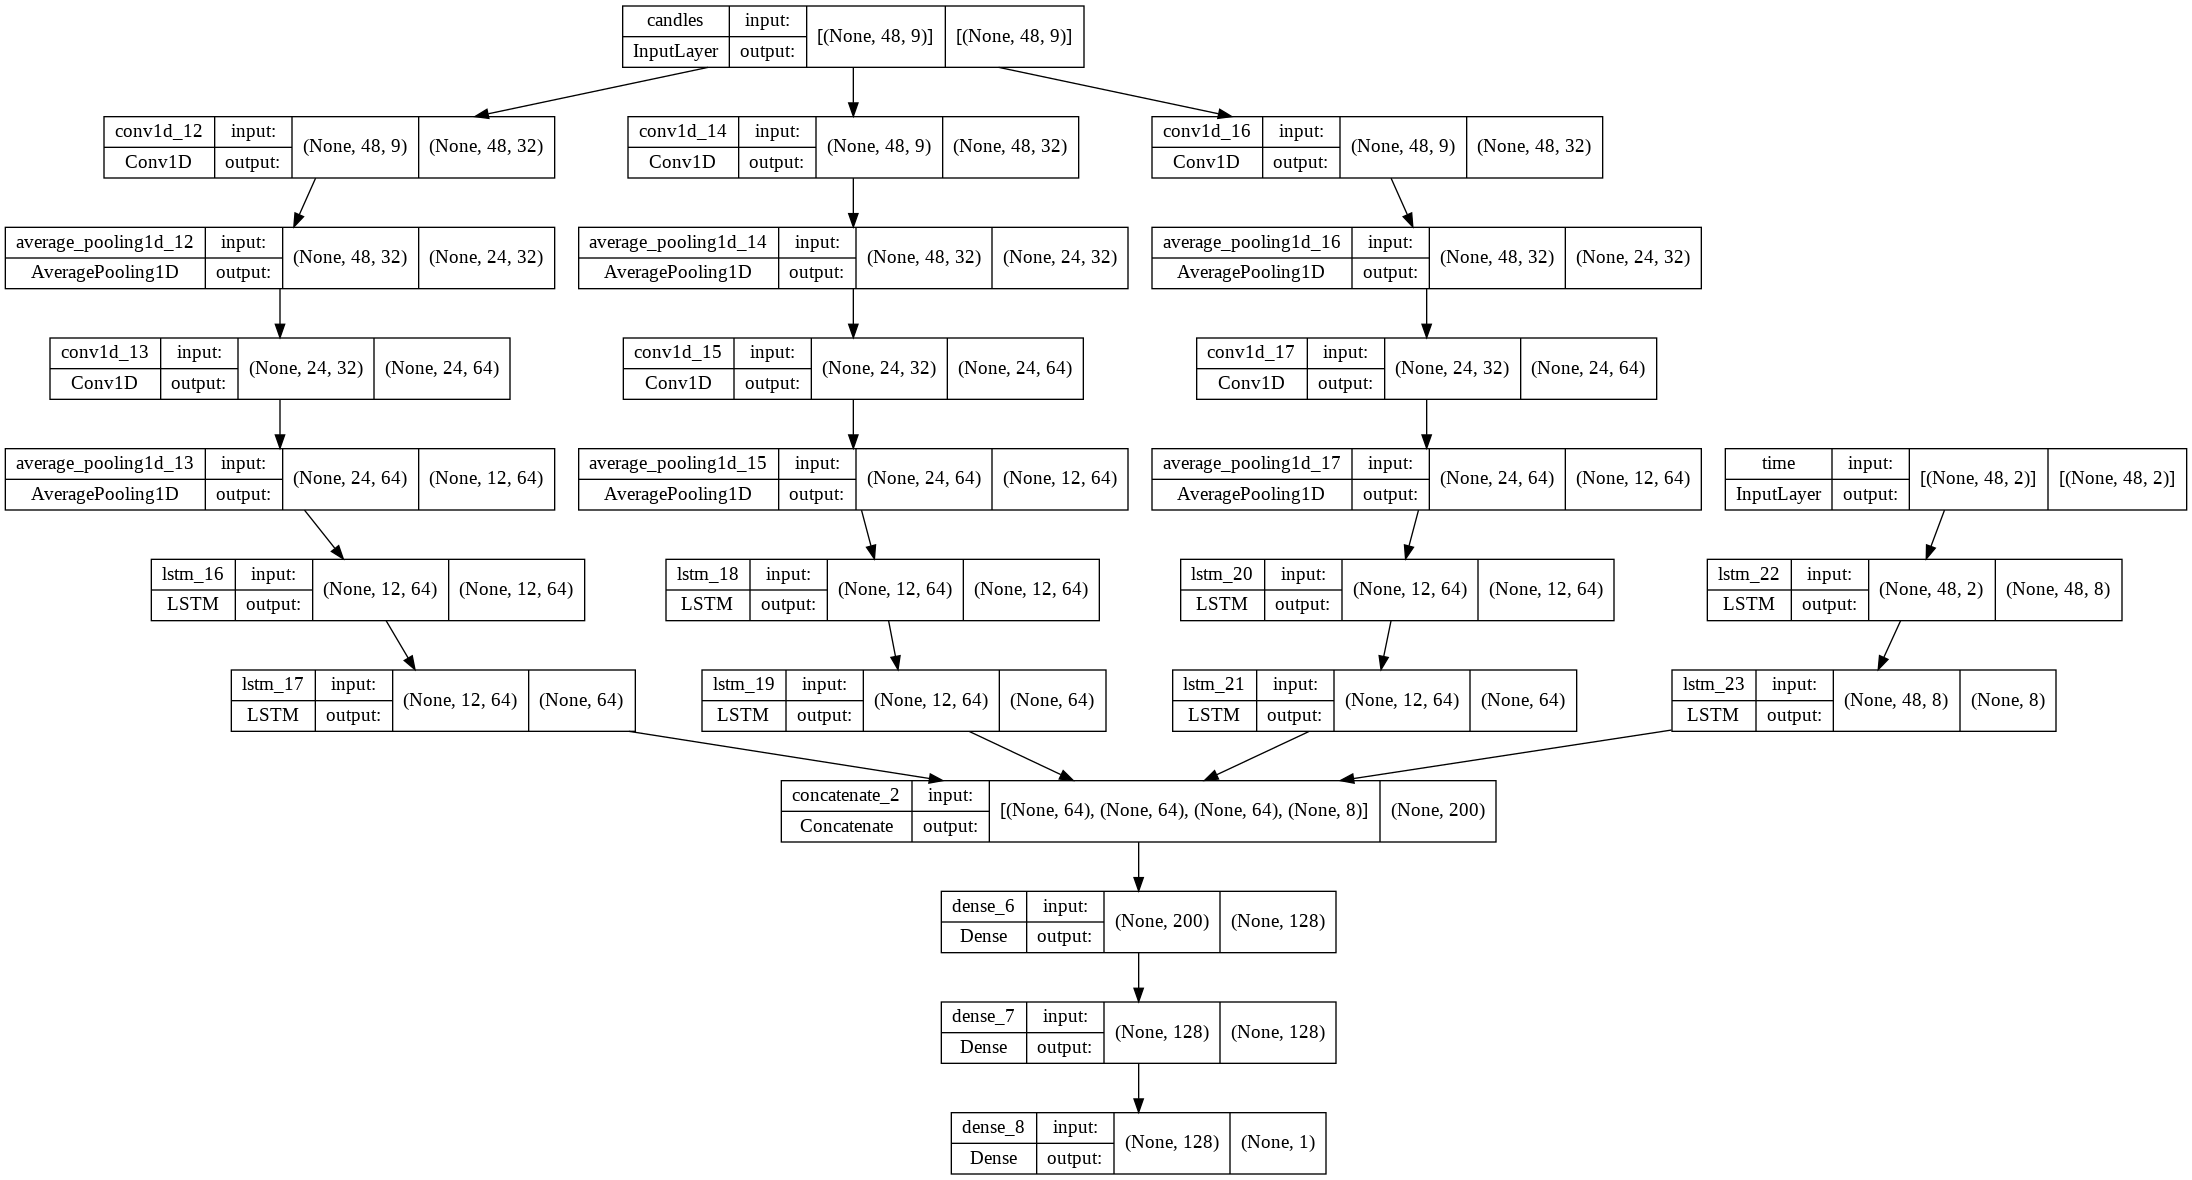

In [167]:
keras.utils.plot_model(btc_model.model, "conv_lstm_net.png", show_shapes=True)

In [168]:
model_name = "model/LSTM_CNN_model"
btc_model.sats2train(model_name,save_model = False)

Epoch 1/20
11/11 [==============================] - 21s 451ms/step - loss: 0.2012 - val_loss: 0.1268
Epoch 2/20
11/11 [==============================] - 1s 106ms/step - loss: 0.0604 - val_loss: 0.1106
Epoch 3/20
11/11 [==============================] - 1s 103ms/step - loss: 0.0373 - val_loss: 0.0528
Epoch 4/20
11/11 [==============================] - 1s 104ms/step - loss: 0.0262 - val_loss: 0.0575
Epoch 5/20
11/11 [==============================] - 1s 90ms/step - loss: 0.0536 - val_loss: 0.0517
Epoch 6/20
11/11 [==============================] - 1s 89ms/step - loss: 0.0327 - val_loss: 0.0306
Epoch 7/20
11/11 [==============================] - 1s 106ms/step - loss: 0.0159 - val_loss: 0.0044
Epoch 8/20
11/11 [==============================] - 1s 103ms/step - loss: 0.0090 - val_loss: 0.0051
Epoch 9/20
11/11 [==============================] - 1s 105ms/step - loss: 0.0077 - val_loss: 0.0044
Epoch 10/20
11/11 [==============================] - 1s 104ms/step - loss: 0.0074 - val_loss: 0.0087


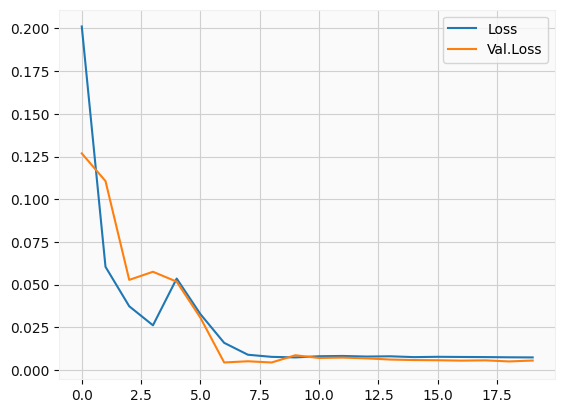

In [169]:
plt.plot(btc_model.history.history['loss'], label='Loss')
plt.plot(btc_model.history.history['val_loss'], label='Val.Loss')
plt.legend(loc="upper right")
plt.show()

In [170]:
btc_model.sats2pred(predict_on_test = True)

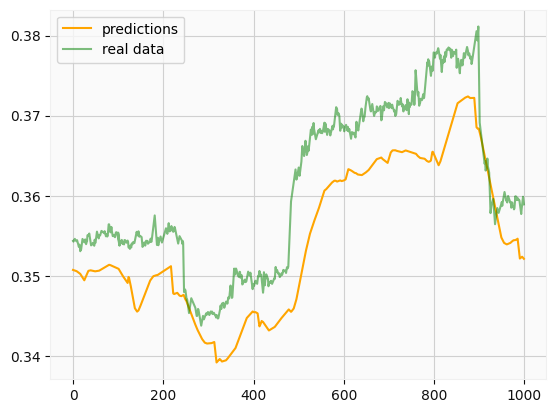

In [171]:
plt.plot(btc_model.preds[-1000:], color='orange', label='predictions')
plt.plot(btc_model.y_test[-1000:], color='green', alpha=0.5, label='real data')
plt.legend()
plt.show()

In [172]:
true_vals = c2t.denorm(ts_btc.scaler, ts_btc.candles, ts_btc.candles_norm[:,-1])
preds = c2t.denorm(ts_btc.scaler, ts_btc.candles, btc_model.preds)

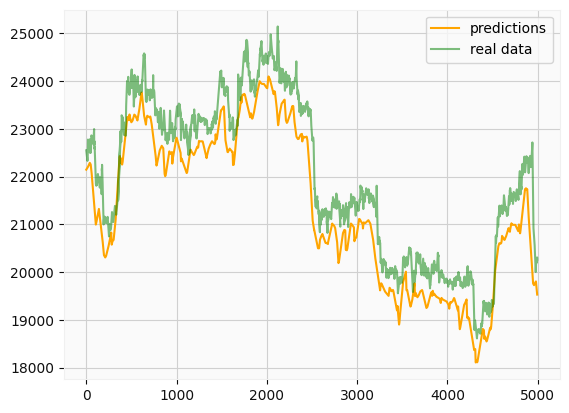

In [173]:
plt.plot(preds[0:len(ts_btc.x_candles)-btc_model.split_point], color='orange', label='predictions')
plt.plot(true_vals[btc_model.split_point:len(ts_btc.x_candles)], color='green', alpha=0.5, label='real data')
plt.legend()
plt.show()

In [174]:
def format_time(t):
    m_, s = divmod(t, 60)
    h, m = divmod(m_, 60)
    return f'{h:>02.0f}:{m:>02.0f}:{s:>02.0f}'

In [175]:
class FixedCommisionScheme(bt.CommInfoBase):
    """
    Simple fixed commission scheme for demo
    """
    params = (
        ('commission', .02),
        ('stocklike', True),
        ('commtype', bt.CommInfoBase.COMM_FIXED),
    )

    def _getcommission(self, size, price, pseudoexec):
        return abs(size) * self.p.commission

OHLCV = ['open', 'high', 'low', 'close', 'volume']

class SignalData(PandasData):
    """
    Define pandas DataFrame structure
    """
    cols = OHLCV + ['predicted']

    # create lines
    lines = tuple(cols)

    # define parameters
    params = {c: -1 for c in cols}
    params.update({'datetime': None})
    params = tuple(params.items())

In [176]:
class CommInfoFractional(bt.CommissionInfo):
    """
    Allow fractions of assets/currencies
    """
    def getsize(self, price, cash):
        '''Returns fractional size for cash operation @price'''
        return self.p.leverage * (cash / price)


class MLStrategy(bt.Strategy):
    params = (('n_positions', 25),
              ('min_positions', 20),
              ('verbose', False),
              ('log_file', 'backtest.csv'))

    def log(self, txt, dt=None):
        """ Logger for the strategy"""
        dt = dt or self.datas[0].datetime.datetime(0)
        with Path(self.p.log_file).open('a') as f:
            log_writer = csv.writer(f)
            log_writer.writerow([dt.isoformat()] + txt.split(','))

    def notify_order(self, order):
        if order.status in [order.Submitted, order.Accepted]:
            return

        # Check if an order has been completed
        # broker could reject order if not enough cash
        if self.p.verbose:
            if order.status in [order.Completed]:
                p = order.executed.price
                if order.isbuy():
                    self.log(f'{order.data._name},BUY executed,{p:.2f}')
                elif order.issell():
                    self.log(f'{order.data._name},SELL executed,{p:.2f}')

            elif order.status in [order.Canceled, order.Margin, order.Rejected]:
                self.log(f'{order.data._name},Order Canceled/Margin/Rejected')

    # bt calls prenext instead of next unless
    # all datafeeds have current values
    # => call next to avoid duplicating logic
    def prenext(self):
        self.next()

    def next(self):
        today = self.datas[0].datetime.date()
#         if today.weekday() not in [0, 3]: # only trade on Mondays;
#             return
        positions = [d._name for d, pos in self.getpositions().items() if pos]
        up, down = {}, {}
        missing = not_missing = 0
        for data in self.datas:
            #print(data.datetime.date(),today)
            if data.datetime.date() == today:
                if data.predicted[0] > 0:
                    up[data._name] = data.predicted[0]
                elif data.predicted[0] < 0:
                    down[data._name] = data.predicted[0]

        # sort dictionaries ascending/descending by value
        # returns list of tuples
        shorts = sorted(down, key=down.get)[:self.p.n_positions]
        longs = sorted(up, key=up.get, reverse=True)[:self.p.n_positions]
        n_shorts, n_longs = len(shorts), len(longs)
        
        # only take positions if at least min_n longs and shorts
        if n_shorts < self.p.min_positions or n_longs < self.p.min_positions:
            longs, shorts = [], []
        for ticker in positions:
            if ticker not in longs + shorts:
                self.order_target_percent(data=ticker, target=0)
                self.log(f'{ticker},CLOSING ORDER CREATED')
                
        short_target = -1 / max(self.p.n_positions, n_shorts)
        long_target = 1 / max(self.p.n_positions, n_longs)
        for ticker in shorts:
            self.order_target_percent(data=ticker, target=short_target)
            self.log('{ticker},SHORT ORDER CREATED')
        for ticker in longs:
            self.order_target_percent(data=ticker, target=long_target)
            self.log('{ticker},LONG ORDER CREATED')

## Back-testing buy or do nothing, i.e. up-only

In [177]:
from time import time

cerebro = bt.Cerebro()  # create a "Cerebro" instance
cash = 10000
# comminfo = FixedCommisionScheme()
# cerebro.broker.addcommissioninfo(comminfo)
cerebro.broker.setcash(cash)

OHLCV = ['open', 'high', 'low', 'close', 'volume']
OHLCV_cap = list(map(lambda x:x.capitalize() ,OHLCV))

up_or_down = list(map(lambda x: 1. if x> 0 else -1. ,  tu.log_return(pd.Series(np.array(btc_model.preds.squeeze())),periods=-1)))
df_updown_true =  tu.merge_true_preds(can_btc.candles,up_or_down,period = 1)

df_preds_true_ohlcv = tu.merge_true_preds(can_btc.candles,preds,period = 1,
                                          columns = OHLCV_cap).reset_index().rename(
                                          columns = {i:j for i,j in 
                                                     zip(["Date","Pred Close"] + 
                                                OHLCV_cap,["date","predicted"] +
                                                OHLCV)})
                                          
df_preds_true_ohlcv["ticker"] = "BTCUSD"
df_updown_true["ticker"] ="BTCUSD"      
df_updown_true.index.name="date"
df_updown_true = df_updown_true.reset_index().set_index(["ticker","date"])

data = df_preds_true_ohlcv.set_index(['ticker','date'])
first_column = data.pop('predicted')
data.insert(0, 'predicted', df_updown_true["Pred Close"])
data=data.dropna()

idx = pd.IndexSlice
#data = pd.read_hdf('00_data/backtest.h5', 'data').sort_index()
tickers = data.index.get_level_values(0).unique()

for ticker in tickers:
    df = data.loc[idx[ticker, :], :].droplevel('ticker', axis=0)
    df.index.name = 'datetime'
    bt_data = SignalData(dataname=df)
    cerebro.adddata(bt_data, name=ticker)


cerebro.addanalyzer(bt.analyzers.PyFolio, _name='pyfolio')
cerebro.addstrategy(MLStrategy, n_positions=1, min_positions=0, 
                    verbose=True, log_file='bt_log.csv')
start = time()
# use the fractional scheme if requested
cerebro.broker.addcommissioninfo(CommInfoFractional())
results = cerebro.run()
ending_value = cerebro.broker.getvalue()
duration = time() - start

print(f'Final Portfolio Value: {ending_value:,.2f}')
print(f'Duration: {format_time(duration)}')

Final Portfolio Value: 10,423.82
Duration: 00:00:30


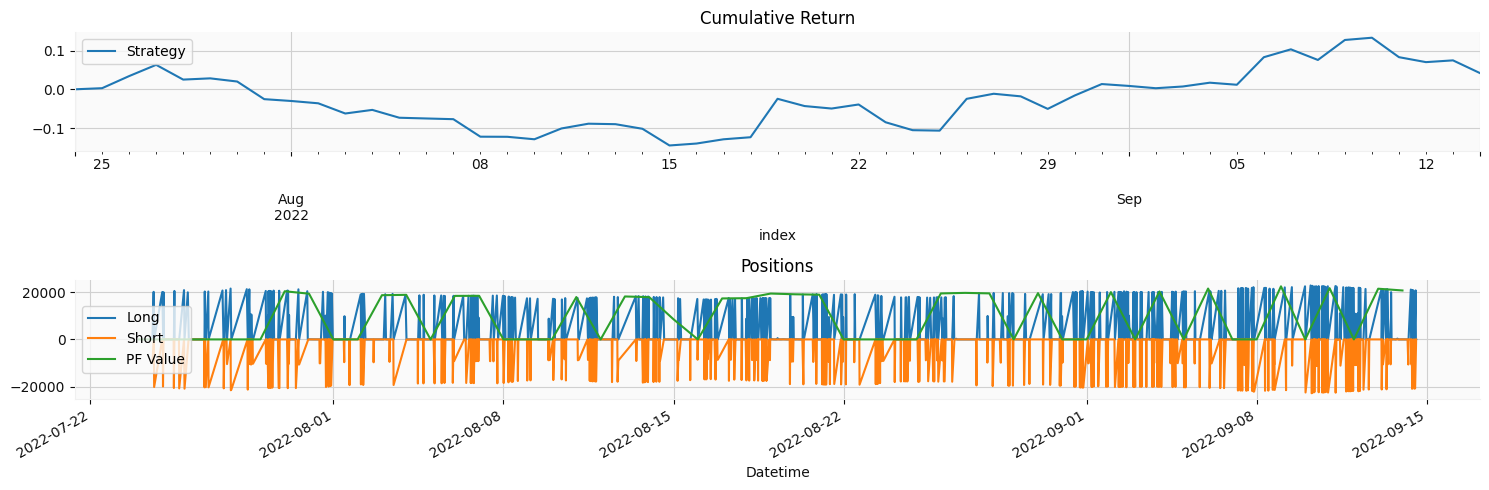

In [178]:
# prepare pyfolio inputs
pyfolio_analyzer = results[0].analyzers.getbyname('pyfolio')
returns, positions, transactions, gross_lev = pyfolio_analyzer.get_pf_items()
daily_tx = transactions.groupby(level=0)

longs = daily_tx.value.apply(lambda x: x.where(x>0).sum())
shorts = daily_tx.value.apply(lambda x: x.where(x<0).sum())

fig, axes = plt.subplots(nrows=2, figsize=(15, 5))

df = returns.to_frame('Strategy')#.join(benchmark.to_frame('Benchmark (S&P 500)'))
df.add(1).cumprod().sub(1).plot(ax=axes[0], title='Cumulative Return')

longs.plot(label='Long',ax=axes[1], title='Positions')
shorts.plot(ax=axes[1], label='Short')
positions.cash.plot(ax=axes[1], label='PF Value')
axes[1].legend()
sns.despine()
fig.tight_layout();

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1951: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[selected_item_labels] = value


Initial time 2022-07-24 10:00:00
Final time 2022-09-14 10:30:00
Fee: 0.025
----------------------
Buy      0 ( 0 ok 0 ko )
Avg PCT gain: 0
Avg PCT loss: 0
Wins  PCT   0.0
Avg PCT Gain.    0
No-op    4946
Wallet   0
Drawback 0
Kelly Fraction    nan
Total earned 0


/content/drive/MyDrive/Colab Notebooks/sats4u/src/sats2backtest.py:432: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
  axes[1].stem(wallet_hist_df.index, wallet_hist_df.iloc[:, 1])


ValueError: ignored

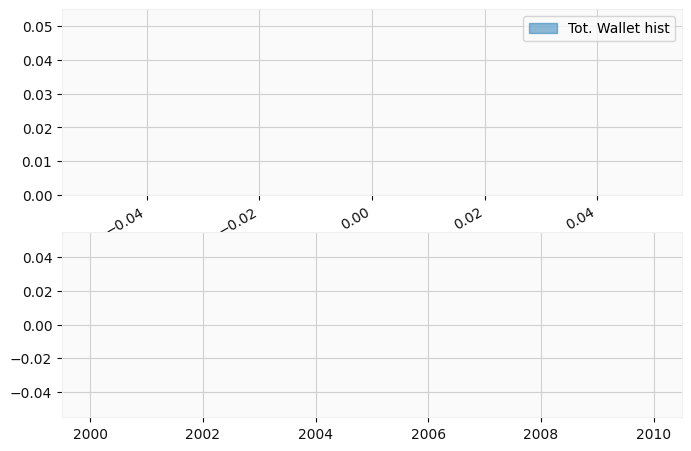

In [113]:
# wallet_hist_df, wallet, kelly_frac = s2b.backtest_df(df_preds_true.dropna(), step_back=+ 48,
#                                                 long_short = "long", compare_true_data=True,
#                                                 fee=0.025, cutoff_long =10. ,cutoff_short = 10.0)
# s2b.show_backtest_results(wallet,wallet_hist_df)

## Train for more epochs

In [114]:
preds_old = btc_model.preds
y_test_old = btc_model.y_test

In [115]:
btc_model.sats2train(model_name, save_model = False, epochs = 100)

Epoch 1/100
11/11 [==============================] - 1s 108ms/step - loss: 0.0075 - val_loss: 0.0058
Epoch 2/100
11/11 [==============================] - 1s 90ms/step - loss: 0.0077 - val_loss: 0.0049
Epoch 3/100
11/11 [==============================] - 1s 106ms/step - loss: 0.0074 - val_loss: 0.0049
Epoch 4/100
11/11 [==============================] - 1s 90ms/step - loss: 0.0075 - val_loss: 0.0046
Epoch 5/100
11/11 [==============================] - 1s 104ms/step - loss: 0.0074 - val_loss: 0.0039
Epoch 6/100
11/11 [==============================] - 1s 104ms/step - loss: 0.0072 - val_loss: 0.0043
Epoch 7/100
11/11 [==============================] - 1s 90ms/step - loss: 0.0073 - val_loss: 0.0051
Epoch 8/100
11/11 [==============================] - 1s 90ms/step - loss: 0.0073 - val_loss: 0.0046
Epoch 9/100
11/11 [==============================] - 1s 106ms/step - loss: 0.0072 - val_loss: 0.0044
Epoch 10/100
11/11 [==============================] - 1s 106ms/step - loss: 0.0072 - val_loss: 

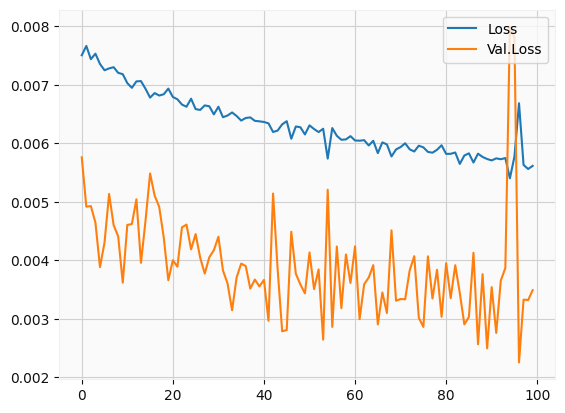

In [116]:
plt.plot(btc_model.history.history['loss'], label='Loss')
plt.plot(btc_model.history.history['val_loss'], label='Val.Loss')
plt.legend(loc="upper right")
plt.show()

In [117]:
btc_model.sats2pred(predict_on_test = True)

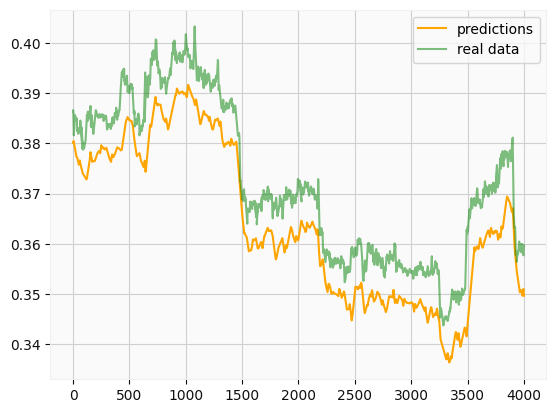

In [148]:
plt.plot(btc_model.preds[-4001:], color='orange', label='predictions')
plt.plot(btc_model.y_test[-4000:], color='green', alpha=0.5, label='real data')
plt.legend()
plt.show()

In [119]:
true_vals = c2t.denorm(ts_btc.scaler, ts_btc.candles, ts_btc.candles_norm[:,-1])
preds = c2t.denorm(ts_btc.scaler, ts_btc.candles, btc_model.preds)

In [ ]:
df_preds_true = tu.merge_true_preds(can_btc.candles, preds, period=+1)

wallet_hist_df, wallet, kelly_frac = s2b.backtest_df(df_preds_true.dropna(), step_back=+ 2,
                                                     long_short="long", fee=0.025, cutoff_long=20., cutoff_short=20.0)
s2b.show_backtest_results(wallet, wallet_hist_df)


In [ ]:
df_pred_exp = pd.DataFrame(np.array([preds,true_vals[-len(preds):]]).T,columns=["Predicted","Expected"])

df_pred_exp["Return Expected"] = tu.log_return(df_pred_exp["Expected"],periods=-1)
df_pred_exp["Return Predicted"] = tu.log_return(df_pred_exp["Predicted"],periods=-1)


In [ ]:
f, axs = plt.subplots( figsize=(11, 6))
df_pred_exp.iloc[-200:].plot(y="Return Expected",ax=axs)
df_pred_exp.iloc[-200:].plot(y="Return Predicted",ax=axs)